Reproduce plots from: 
The Representation of Sea Salt Aerosols and Their Role in Polar Climate Within CMIP6

GOAL:
- make familiar with Wilcoxon test and dask
- compare parallelized version



(0) Define and regrid the data on a common grid

In [26]:
import os
os.getcwd()

'/home/jovyan/ArditArifi'

In [27]:
source_path="/home/jovyan/prepared-data/POLAR_EMISS_DATA/CMIP6"
processed_path="/home/jovyan/student-storages/GROUP3/ArditArifi/CMIP6_processed"
output_path="/home/jovyan/student-storages/GROUP3/ArditArifi/CMIP6_output"

! mkdir -p {processed_path}
! mkdir -p {output_path}

In [28]:
grid_description = """
gridtype = lonlat
xsize = 120
ysize = 90
xfirst = 0.0
xinc = 3.0
yfirst = -90.0
yinc = 2.0
"""

grid_file = "grid_3x2.txt"

# Save the grid description to a file
with open(grid_file, "w") as grid_file:
    grid_file.write(grid_description)

print("Grid description file created: grid_3x2.txt")

Grid description file created: grid_3x2.txt


In [29]:
var = "tas"
! ./reproduce.sh {source_path} {output_path} {var}

cdo    remapbil: Bilinear weights from lonlat (144x143) to lonlat (120x90) grid
cdo    remapbil: Processed 7413120 values from 1 variable over 360 timesteps [0.82s 87MB].
Regridded: /home/jovyan/prepared-data/POLAR_EMISS_DATA/CMIP6/tas_Amon_IPSL-CM6A-LR-INCA_piClim-2xss_r1i1p1f1_gr_185001-187912.nc -> /home/jovyan/student-storages/GROUP3/ArditArifi/CMIP6_output/tas_Amon_IPSL-CM6A-LR-INCA_piClim-2xss_r1i1p1f1_gr_185001-187912.nc
cdo    remapbil: Bilinear weights from lonlat (144x143) to lonlat (120x90) grid
cdo    remapbil: Processed 7413120 values from 1 variable over 360 timesteps [0.88s 87MB].
Regridded: /home/jovyan/prepared-data/POLAR_EMISS_DATA/CMIP6/tas_Amon_IPSL-CM6A-LR-INCA_piClim-control_r1i1p1f1_gr_185001-187912.nc -> /home/jovyan/student-storages/GROUP3/ArditArifi/CMIP6_output/tas_Amon_IPSL-CM6A-LR-INCA_piClim-control_r1i1p1f1_gr_185001-187912.nc
cdo    remapbil: Bilinear weights from lonlat (144x96) to lonlat (120x90) grid
cdo    remapbil: Processed 1658880 values from 1 va

(1) Reproduce Fig 10.

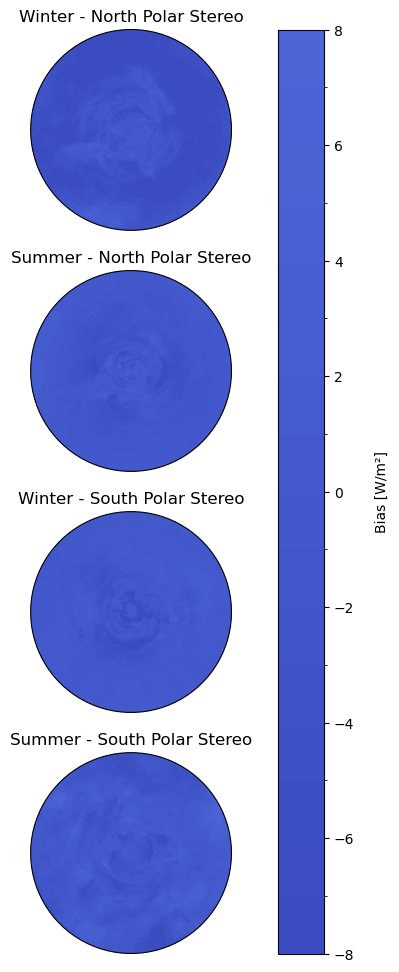

In [71]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors

fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(12, 12),
    subplot_kw={"projection": ccrs.NorthPolarStereo()}
)
axes = axes.flatten()

model = "NorESM2"
var = "rtmt"

# Load data (dummy paths shown)
piClim_2xss = xr.open_mfdataset(f"{source_path}/rtmt*{model}*piClim-2xss*.nc", combine="by_coords")
piClim_control = xr.open_mfdataset(f"{source_path}/rtmt*{model}*piClim-control*.nc", combine="by_coords")

# Calculate bias
bias = piClim_2xss[var] - piClim_control[var]

# Winter / Summer (time-mean)
bias_winter = bias.where((bias["time.month"] > 11) | (bias["time.month"] < 3), drop=True).mean("time")
bias_summer = bias.where((bias["time.month"] > 5) & (bias["time.month"] < 9), drop=True).mean("time")

# Define discrete levels and a normalizer for color segmentation
vmin, vmax = -8, 8
levels = np.arange(vmin, vmax + 1, 1)

# 1) Winter (Arctic)
p = bias_winter.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    vmin = vmin, vmax = vmax,
    add_colorbar=False
)
axes[0].set_title("Winter - North Polar Stereo")

# 2) Summer (Arctic)
bias_summer.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    vmin = vmin, vmax = vmax,
    add_colorbar=False
)
axes[1].set_title("Summer - North Polar Stereo")

# 3) Winter (Antarctic)
axes[2].projection = ccrs.SouthPolarStereo() 
bias_winter.plot(
    ax=axes[2],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    vmin = vmin, vmax = vmax,
    add_colorbar=False
)
axes[2].set_title("Winter - South Polar Stereo")

# 4) Summer (Antarctic)
axes[3].projection = ccrs.SouthPolarStereo()
bias_summer.plot(
    ax=axes[3],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    vmin = vmin, vmax = vmax,
    add_colorbar=False
)
axes[3].set_title("Summer - South Polar Stereo")

# Create ONE shared colorbar on the right
cbar = fig.colorbar(
    p, 
    ax=axes,
    orientation="vertical",
    ticks=levels,
    location="right"  # or "left"
)

# Place the label on the left side of the colorbar
cbar.set_label("Bias [W/m²]", labelpad=15)
cbar.ax.locator_params(nbins=len(levels) - 1)
